# Модуль Б.  Разведочный анализ данных

### 2.1 Поиск ключевых слов/n-грамм. Векторизация текстов

**Логарифмирование**

*Самый очевидный способ формирования признакового описания текстов — векторизация. Простой способ заключается в подсчёте, сколько раз встретилось каждое слово в тексте. Получаем вектор длиной в количество уникальных слов, встречающихся во всех объектах выборки. В таком векторе много нулей, поэтому его удобнее хранить в разреженном виде.
Пусть у нас имеется коллекция текстов D={di}li=1 и словарь всех слов, встречающихся в выборке V={vj}dj=1.В этом случае некоторый текст описывается вектором (xij)dj=1, где.*

\begin{equation*}
x_{ij}=\left(\sum_{v∈d_i}[v=v_j] \right)
\end{equation*}

*Таким образом, текст описывается вектором количества вхождений каждого слова из словаря в данный текст.*

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8', min_df=1)
_ = vectorizer.fit(data)

In [6]:
vectorizer.transform(data[:1])

<7x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(encoding='utf8', min_df=1)
_ = vectorizer.fit(data)

In [8]:
stemmer = nltk.stem.snowball.EnglishStemmer()
def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts = []
for t in tqdm(data[:1000]):
    stemmed_texts.append(stem_text(t, stemmer))

 18%|████████████████▎                                                                          | 7/39 [00:00<?, ?it/s]


In [9]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

*Для векторизации текста я буду использовать алгоритм линейной регрессии, так как по полученным коэффициентам регрессии можно судить о том, как тот или иной фактор влияет на результат, а значит, этот алгоритм сможет более точно определить повторяющие слова.*

In [10]:
text=data.copy()

In [11]:
lbl=LabelEncoder()
non_nomic=data.select_dtypes(exclude=[np.number])
non_momic_cols=non_nomic.columns.values
for col in non_momic_cols:
    data[col]=lbl.fit_transform(data[col].astype(str))

In [12]:
data = data.drop(columns=["name"])
y = data["rate"]
X = data.drop(columns=["rate"])

C:\Users\blend\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blend\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


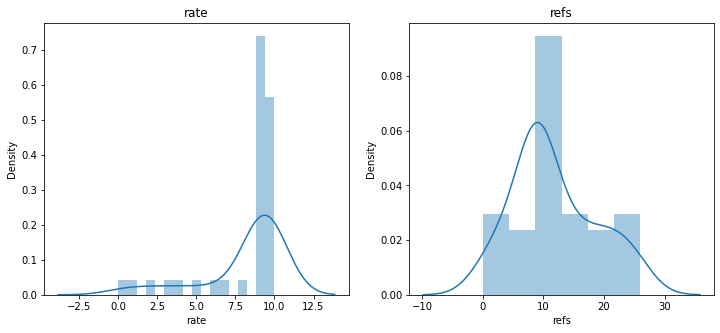

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(y, label='rate')
plt.title('rate')
plt.subplot(1, 2, 2)
sns.distplot(data.refs, label='refs')
plt.title('refs')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

C:\Users\blend\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


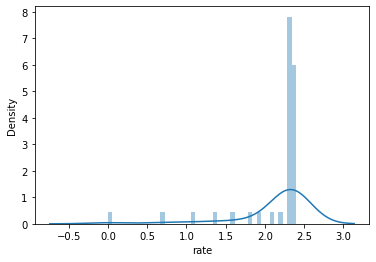

In [15]:
sns.distplot(np.log(y+1), label='target')
plt.show()

In [16]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 1.8101


In [17]:
model = Ridge()
model.fit(X_train, np.log(y_train+1))
y_pred = np.exp(model.predict(X_test))-1
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 2.3835


*Можно заметить, что после обучения на линейной регрессии, точность увеличилась, а значит алгоритм был подобран верно.*

**Бинаризация**

In [18]:
from sklearn.linear_model import LinearRegression
np.random.seed(36)
X = np.random.uniform(0, 1, size=100)
y = np.cos(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)

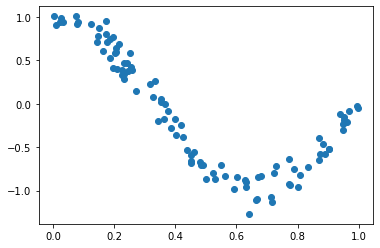

In [19]:
plt.scatter(X, y)

In [20]:
X = X.reshape((-1, 1))
thresholds = np.arange(0.2, 1.1, 0.2).reshape((1, -1))

X_expand = np.hstack((
    X,
    ((X > thresholds[:, :-1]) & (X <= thresholds[:, 1:])).astype(int)))

### 2.2 Тематическое моделирование

*У нас есть все необходимое для обучения модели LDA. В дополнение к корпусу и словарю необходимо также указать количество тем.Кроме того, alpha и eta являются гиперпараметрами, которые влияют на разреженность тем. Согласно документации Gensim, оба значения по умолчанию равны 1.0 / num_topics.chunksize – это количество документов, которые будут использоваться в каждом обучающем чанке. update_every определяет, как часто параметры модели должны обновляться, а passes – это общее количество проходов обучения.*

In [21]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

**LDA**

*В LDA каждый документ может рассматриваться как набор случайных скрытых тем, где каждая тема определяется распределением слов, при этом каждое слово в конкретном документе можно отнести к одной из его тем. Подобный подход схож с pLSA с той разницей, что в LDA качестве априорного распределения для тем используется распределение Дирихле. Это улучшает качество получающихся тем.*

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(text['refs'].values.astype('U'))

In [24]:
doc_term_matrix

<39x2771 sparse matrix of type '<class 'numpy.int64'>'
	with 8299 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [26]:
import random
for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])


маркетинговых
ему
своё
технологиях
динамику
ваша
получил
nсразу
специалистов
поддержка


C:\Users\blend\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
first_topic = LDA.components_[0]

In [28]:
print(first_topic)

[4.6248099  2.20000171 5.10494589 ... 0.22657943 0.20000022 0.20000002]


C:\Users\blend\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


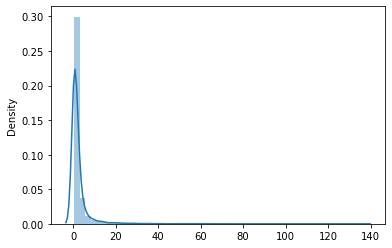

In [29]:
sns.distplot(first_topic, label='target')
plt.show()

In [30]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['информационных', 'системы', 'что', 'модели', 'данных', 'не', 'xa0', 'для', 'на', 'по']


Top 10 words for topic #1:
['киберспорта', 'для', 'nan', 'киберспорт', 'то', 'не', 'по', 'что', 'это', 'на']


Top 10 words for topic #2:
['есть', 'вы', 'мы', 'для', 'как', 'на', 'это', 'не', 'то', 'что']


Top 10 words for topic #3:
['или', 'также', 'это', 'как', 'по', 'для', 'что', 'не', 'мы', 'на']


Top 10 words for topic #4:
['при', 'году', 'развитие', 'правительство', 'не', 'москвы', 'на', 'для', 'по', 'проект']




C:\Users\blend\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(39, 5)

In [32]:
text['topic'] = topic_values.argmax(axis=1)

In [33]:
text.head()

,Unnamed: 0,date,refs,name,rate,activity,description,topic
0,0,2023 05 19t16 59 55 000z,дисклеймер не повторяйте в домашних условиях с...,ruvds com,6 1,связь и телекоммуникации,международный облачный провайдер ruvds предлаг...,2
1,1,2023 05 19t16 20 33 000z,продолжаю цикл статей по разработке etl процес...,selectel,6 1,аппаратное обеспечение,selectel ведущий в россии провайдер облачной и...,2
2,2,2023 05 19t16 13 11 000z,давно интересовался как можно объединить микро...,timeweb cloud,6 1,веб разработка,timeweb cloud облачный сервис сочетающий масс...,2
3,3,2023 05 19t16 00 01 000z,сингапур известен своей развитой экономикой и ...,otus,6 1,консалтинг и поддержка,otus сообщество профессионалов которые помогут...,1
4,4,2023 05 19t15 03 46 000z,друзья продолжаем публиковать решения нашего c...,firstvds,6 1,связь и телекоммуникации,размещаем сайты клиентов на виртуальных и выде...,3


**NMF**

*Неотрицательная матричная факторизация также является контролируемым методом обучения, который выполняет кластеризацию, а также уменьшение размерности. Он может быть использован в сочетании со схемой TF-IDF для выполнения тематического моделирования.*

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(text['refs'].values.astype('U'))

In [35]:
import random
for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

которых
участвовать
компаниям
источников
передачу
примера
оно
необходимость
весьма
первоначально


C:\Users\blend\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(doc_term_matrix )

C:\Users\blend\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5, random_state=42)

In [38]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

C:\Users\blend\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


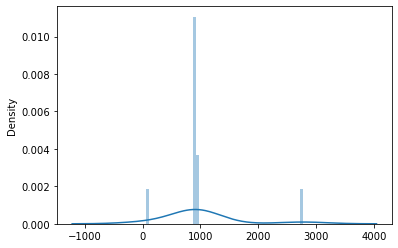

In [39]:
sns.distplot(top_topic_words, label='target')
plt.show()

In [41]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['концов', 'кооперации', 'копейки', 'копирайт', 'короткий', 'короче', 'корпоратив', 'концепция', 'ящик', 'nan']


Top 10 words for topic #1:
['но', 'или', 'мы', 'для', 'как', 'на', 'это', 'то', 'не', 'что']


Top 10 words for topic #2:
['зовут', 'эксперимент', 'провели', 'опытом', 'мы', 'занимаюсь', 'микрофронтендов', 'мальченко', 'евгений', 'qiwi']


Top 10 words for topic #3:
['разработке', 'статьи', 'процессов', 'как', 'объединить', 'для', 'пк', 'процесс', 'python', 'на']


Top 10 words for topic #4:
['на', 'xa0', 'года', 'вшэ', 'правительство', 'программы', 'москвы', 'киберспорта', 'проект', 'по']




C:\Users\blend\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['концов', 'кооперации', 'копейки', 'копирайт', 'короткий', 'короче', 'корпоратив', 'концепция', 'ящик', 'nan']


Top 10 words for topic #1:
['но', 'или', 'мы', 'для', 'как', 'на', 'это', 'то', 'не', 'что']


Top 10 words for topic #2:
['зовут', 'эксперимент', 'провели', 'опытом', 'мы', 'занимаюсь', 'микрофронтендов', 'мальченко', 'евгений', 'qiwi']


Top 10 words for topic #3:
['разработке', 'статьи', 'процессов', 'как', 'объединить', 'для', 'пк', 'процесс', 'python', 'на']


Top 10 words for topic #4:
['на', 'xa0', 'года', 'вшэ', 'правительство', 'программы', 'москвы', 'киберспорта', 'проект', 'по']




In [43]:
topic_values = nmf.transform(doc_term_matrix)
text['topic_2'] = topic_values.argmax(axis=1)
text.head()

,Unnamed: 0,date,refs,name,rate,activity,description,topic,topic_2
0,0,2023 05 19t16 59 55 000z,дисклеймер не повторяйте в домашних условиях с...,ruvds com,6 1,связь и телекоммуникации,международный облачный провайдер ruvds предлаг...,2,1
1,1,2023 05 19t16 20 33 000z,продолжаю цикл статей по разработке etl процес...,selectel,6 1,аппаратное обеспечение,selectel ведущий в россии провайдер облачной и...,2,3
2,2,2023 05 19t16 13 11 000z,давно интересовался как можно объединить микро...,timeweb cloud,6 1,веб разработка,timeweb cloud облачный сервис сочетающий масс...,2,3
3,3,2023 05 19t16 00 01 000z,сингапур известен своей развитой экономикой и ...,otus,6 1,консалтинг и поддержка,otus сообщество профессионалов которые помогут...,1,4
4,4,2023 05 19t15 03 46 000z,друзья продолжаем публиковать решения нашего c...,firstvds,6 1,связь и телекоммуникации,размещаем сайты клиентов на виртуальных и выде...,3,4


**LSI (LSA)**

*Проблема этого метода в том, что он предполагает, что слова и документы имеют нормальное распределение, но в реальности это не так. Поэтому на практике чаще используется pLSA, основанный на мультиномиальном распределении. Если LSA — это чистая линейная алгебра, то pLSA имеет еще и статистические основания.Согласно pLSA, совместная встречаемость терма и документа  (w,d)  моделируется как сочетание независимых мультиномиальных распределений, где  c  — тема. Количество тем — это гиперпараметр, который выбирается до начала анализа.*

In [44]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [45]:
from sklearn.decomposition import LatentDirichletAllocation
SVD = TruncatedSVD(n_components=5, random_state=42)
SVD.fit(doc_term_matrix)

TruncatedSVD(n_components=5, random_state=42)

In [46]:
import random
for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])


сложные
изначального
сайта
создали
идут
случаев
решать
вторых
оплаты
разработчиков


C:\Users\blend\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
first_topic = SVD.components_[0]

In [48]:
print(first_topic)

[ 2.51551621e-09  5.03146751e-10 -4.01487008e-09 ...  3.65296449e-10
  3.35955252e-09 -6.75575740e-10]


C:\Users\blend\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


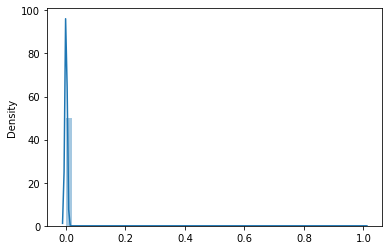

In [49]:
sns.distplot(first_topic, label='target')
plt.show()

*Исходя из реализованных алгоритмов можно сделать вывод, что, лучшим алгоритмом для иходных данных является -  NMF, так как он показал наиболее выокую вероятность обучения*

### 2.3 Кластеризация

In [50]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

*Для того, что-бы приступить к обучению модели, необходимо выбрать алгоритмы для кластеризации.Наиболее подходящим алгоритмом будет являться:k-means- из-за простоты в реализации, и умении работать с большим количеством значений, PCA-он основан на уменьшении размерности выборки, TSNE-преимущества такиеже как и у анализа главных компонентов.*

In [52]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

**PCA**

In [53]:
x = data.drop('refs', 1)
y = data['refs']

C:\Users\blend\AppData\Local\Temp\ipykernel_7844\2952694243.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = data.drop('refs', 1)


In [54]:
pca = decomposition.PCA(n_components=4)
X_pca=pca.fit_transform(x)
print("Количество признаков после обработки PCA: {0}".format(X_pca.shape[1]))

Количество признаков после обработки PCA: 4


In [55]:
print(format(sum(pca.explained_variance_ratio_)))

0.9926486084591094


In [56]:
print("Точность после обработки PCA:{0}".format(silhouette_score(X_pca,y)))

Точность после обработки PCA:0.25905275317138315


**t-SNE**

In [57]:
samples = data.iloc[:, :-1].values
varieties = data.iloc[:, -1].values

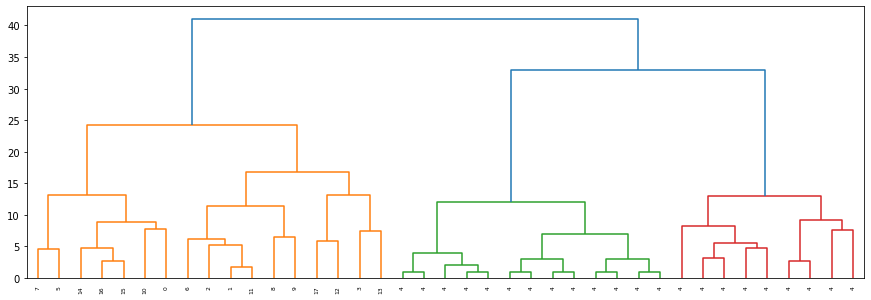

In [58]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the linkage: mergings
mergings = linkage(samples, method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(15, 5))
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
          );

In [59]:
tsne = TSNE(learning_rate=50)

In [60]:
y_pred_tsne=tsne.fit_transform(x)

C:\Users\blend\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [61]:
print("Количество признаков после обработки t-SNE: {0}".format(y_pred_tsne.shape[1]))

Количество признаков после обработки t-SNE: 2


In [62]:
print("Точность после обработки t-SNE:{0}".format(silhouette_score(y_pred_tsne,y)))

Точность после обработки t-SNE:0.2655460834503174


**k-means**

In [63]:
mean=KMeans(n_clusters=4, random_state=101)

In [64]:
y_pred_means=mean.fit_transform(x)

In [65]:
print("Количество признаков после обработки k_means: {0}".format(y_pred_means.shape[1]))

Количество признаков после обработки k_means: 4


In [66]:
print("Точность после обработки k_means:{0}".format(silhouette_score(y_pred_means,y)))

Точность после обработки k_means:0.25309736616047496


*Теперь можно сравнить работу алгоритмов*

<AxesSubplot:title={'center':'Cuisine Preference'}, ylabel='model'>

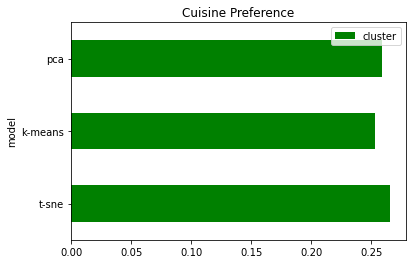

In [67]:
model_comparison = pd.DataFrame({'model': ['t-sne', 'k-means', 'pca'],
                                 'cluster': [silhouette_score(y_pred_tsne,y), silhouette_score(y_pred_means,y), silhouette_score(X_pca,y)]})  
# Plot a bar chart
model_comparison.plot.barh(x='model', y='cluster',
             title='Cuisine Preference', color='green')

*Исходя из графика можно сделать вывод, что лучше всех с обучением справился алгоритм t-sne*

In [68]:
tsne=[]

In [69]:
tsne=y_pred_tsne

In [70]:
tsne=pd.DataFrame(tsne)

In [71]:
del tsne[0]

In [72]:
text["cluster"]=tsne

### 2.4 Разведочный анализ

**Визуализация зависимости кластера от даты**

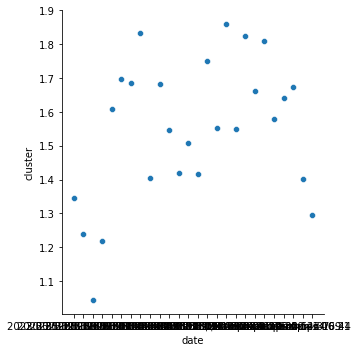

In [73]:
sns.relplot(x ="date", y ="cluster",
            data = text);

*На графике видно, что от кластер от временных признаков зависит хорошо, так как точки кластера лежат на всей плоскости графика.Таже стоит сказать, что чем больше временной признак, тем больше кластеров.*

**Визуализация зависимости кластера от рейтинга**

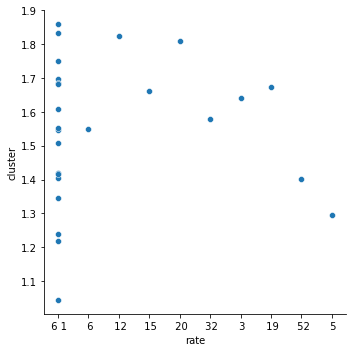

In [74]:
sns.relplot(x ="rate", y ="cluster",
            data = text);

*На данном графике можно увидеть, что рейтинг компании от кластера зависит хорошо, так как точки кластера лежат на всей плоскости графика. Можно увидеть, что больше всего кластеров соответствует рейтинг 6.1*

**Визуализация зависимости кластера от ключевых слов**

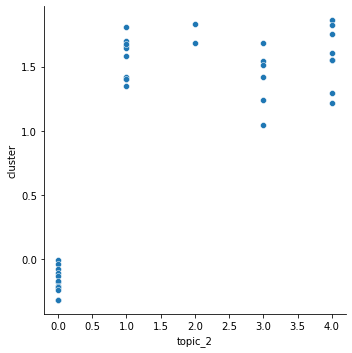

In [75]:
sns.relplot(x ="topic_2", y ="cluster",
            data = text);

*На данном графике можно заметить, что больше всего ключевых слов соответствуют кластеру 1, также можно увидеть, что зависимости ключевых слов от кластерапрактически нет.*

**Визуальный анализ статистики публикаций**

**дальний участок**

In [87]:
text[:2]

,Unnamed: 0,date,refs,name,rate,activity,description,topic,topic_2,cluster
0,0,2023 05 19t16 59 55 000z,дисклеймер не повторяйте в домашних условиях с...,ruvds com,6 1,связь и телекоммуникации,международный облачный провайдер ruvds предлаг...,2,1,1.346571
1,1,2023 05 19t16 20 33 000z,продолжаю цикл статей по разработке etl процес...,selectel,6 1,аппаратное обеспечение,selectel ведущий в россии провайдер облачной и...,2,3,1.237431


In [88]:
lbl=LabelEncoder()
non_nomic=text.select_dtypes(exclude=[np.number])
non_momic_cols=non_nomic.columns.values
for col in non_momic_cols:
    text[col]=lbl.fit_transform(text[col].astype(str))

In [90]:
text[:2]

,Unnamed: 0,date,refs,name,rate,activity,description,topic,topic_2,cluster
0,0,25,15,15,9,8,10,2,1,1.346571
1,1,24,24,17,9,0,7,2,3,1.237431


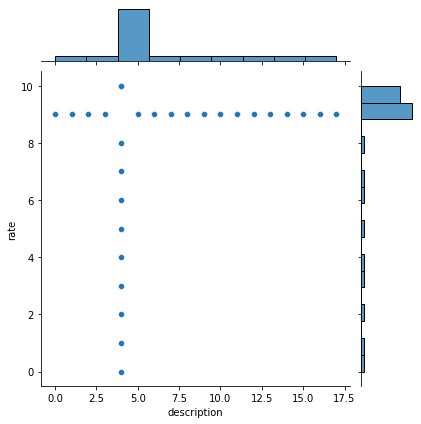

In [92]:
sns.jointplot(x = 'description', y = 'rate', data = text)

*Из графика выше можно увидеть, что больше всего публикацей с рейтингом 9*

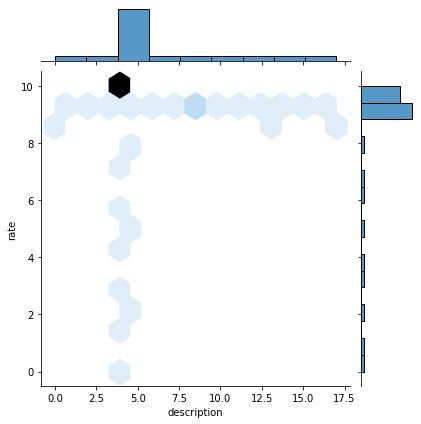

In [86]:
sns.jointplot(x = 'description', y = 'rate', data = data ,kind = 'hex')

*Еще одно четкое визуальное представление, глубина цвета представляет частоту.*

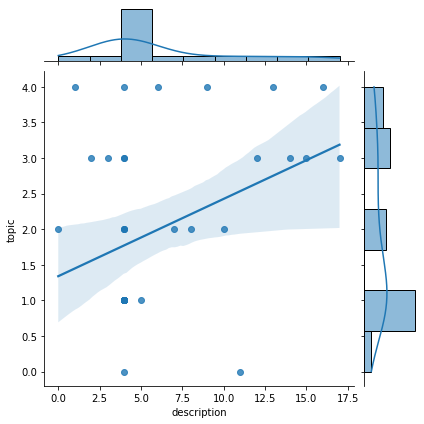

In [93]:
sns.jointplot(x = 'description', y = 'topic', data = text ,kind = 'reg')

*Здесь был осуществлен ввывод графика линейной регрессии, практически все точки лежат рядом с линией, это говорит о том, что у публикации и ключевых слов очень хорошая зависимость*

### 2.5 Подготовка отчета

*В этом модуле продолжается работа с данными, подготовленными в предыдущей сессии. Требуется осуществить выбор алгоритма классификации, построить модель и   провести оптимизацию полученной модели машинного обучения в контексте исследуемой задачи.*